# Estimating VaR and ES for CAT Bonds on North Atlantic Hurricanes with Monte Carlo Simulation and Input Probability of Occurrance estimated via Random Forests

#### Francesco Mosti
#### Master di 2 livello in Data Science and Statistical Learning 2025
#### Università degli Studi di Firenze | IMT Lucca
#### Esame in Statistical Learning - 07/07/2025

## Scope of the Analysis:



This analysis aims to replicate, at an academic level, a simplified framework for estimating VaR (Value at Risk) and ES (Expected Shortfall) for a catastrophe (CAT) bond linked to **hurricane risk**, specifically in the **North Atlantic Basin**.\
The project combines historical data, statistical learning techniques, and Monte Carlo simulation to approximate how insurers and reinsurers assess and price extreme weather risks.\
The historical dataset was built by merging multiple publicly available sources, including the [HURDAT2](https://www.nhc.noaa.gov/data/#hurdat) database for detailed hurricane tracks and characteristics (e.g., minimum central pressure, maximum sustained wind speed, latitude, longitude, season) and additional event-level information (e.g., estimated damages in USD and fatalities) collected from [EM-DAT](https://www.emdat.be) and [Kaggle (LIAMTSAU)](https://www.kaggle.com/datasets/valery2042/hurricanes/data).

Using these datasets, a `Random Forest` classifier is trained to learn the relationship between key pre-event hurricane features:
- Minimum Sea Level Pressure (`mslp`), 
- Accumulated Cyclone Energy (`ace`), 
- Geographic Coordinates.

and the probability that a hurricane will cause significant damage (above a defined monetary threshold).\
This step provides a robust, data-driven estimation of the conditional probability of a catastrophic payout event given a particular storm scenario.

Once trained, the Random Forest is applied to a large number of hypothetical hurricane scenarios generated through alternatively `Bootstrapping` and `Monte Carlo` simulation.\
These scenarios are sampled from distributions or empirical kernels that reflect the historical characteristics of Atlantic hurricanes, while allowing for plausible variability and correlation between variables such as intensity and duration.\
For each scenario, the Random Forest assigns a probability of exceeding the loss threshold. A Bernoulli draw determines whether the simulated event is deemed catastrophic.
If so, an economic loss amount is sampled from a separate severity distribution (e.g., lognormal), reflecting the possible monetary impact.

By repeating this process across thousands or millions of simulated scenarios, the analysis produces a distribution of possible losses for the CAT bond.
From this distribution, key risk measures — including the Expected Loss (EL) and the pure premium — are calculated, illustrating how modern risk models quantify uncertainty and support risk transfer decisions in the insurance and reinsurance markets.

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import stats, skewnorm, gamma, kstest, probplot

# import tropycal package to parse HURDAT2 data 
import tropycal.tracks as tracks

# import kagglehub to retrieve data from kaggle
import kagglehub

# plotting maps
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import contextily as ctx

# Random Forests
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, make_scorer, f1_score, roc_auc_score, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

## Load data from NHC website (HURDAT2 data on Hurricanes)

Retrieve `North Atlantic basin`:

In [4]:
basin = tracks.TrackDataset(basin="north_atlantic")

# parsing con tropycal package for each season, each event is saved as "storm" object

df_all = basin.get_season(2000).to_dataframe()

for season in range(2001,2024):
    df = basin.get_season(season).to_dataframe()
    df_all = pd.concat([df_all,df],ignore_index=True)

df_all.to_csv("hurdat2data.csv", index=False)

--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (1.48 seconds)


### Usage examples of the dataset from NHC

In [5]:
basin.storm_ace_vs_season

<bound method TrackDataset.storm_ace_vs_season of <tropycal.tracks.Dataset>
Dataset Summary:
    Basin:             north_atlantic
    Source:            hurdat
    Number of storms:  1991
    Maximum wind:      165 knots (Allen 1980)
    Minimum pressure:  882 hPa (Wilma 2005)
    Year range:        1851 — 2024>

In [6]:
basin.get_storm(("beryl",2000))
basin.get_season(2000)

<tropycal.tracks.Season>
Season Summary:
    Total Storms:      19
    Named Storms:      15
    Hurricanes:        8
    Major Hurricanes:  3
    Season ACE:        119.2

More Information:
    year:          2000
    basin:         north_atlantic
    source_basin:  north_atlantic
    source:        hurdat
    source_info:   NHC Hurricane Database

## Load more data to obtain a more informative Data Frame

In this section I included data from EM-DAT to retrieve information on damages and fatalities that were not included in the HURDAT2 dataset.\
I merged the two dataframes by storm name and year.

In [7]:
# Download latest version
path = kagglehub.dataset_download("valery2042/hurricanes")

print("Path to dataset files:", path)

Path to dataset files: /Users/francescomosti/.cache/kagglehub/datasets/valery2042/hurricanes/versions/1


In [8]:
hurdat = pd.read_csv("hurdat2data.csv",sep=",")
damage = pd.read_excel("Hurricane Data.xlsx")

hurdat.head()

id     name  vmax  mslp  category   ace           start_time  \
0  AL012000  UNNAMED    25  1008        -1   0.0  2000-06-07 18:00:00   
1  AL022000  UNNAMED    30  1008        -1   0.0  2000-06-23 00:00:00   
2  AL032000  ALBERTO   110   950         3  36.9  2000-08-03 18:00:00   
3  AL042000  UNNAMED    30  1009        -1   0.0  2000-08-08 12:00:00   
4  AL052000    BERYL    45  1007         0   0.9  2000-08-13 18:00:00   

              end_time  start_lat  start_lon  
0  2000-06-08 12:00:00       21.0      -93.0  
1  2000-06-25 18:00:00        9.5      -19.8  
2  2000-08-23 06:00:00       10.8      -18.0  
3  2000-08-11 12:00:00       28.2      -74.2  
4  2000-08-15 18:00:00       22.5      -93.5

In [9]:
damage['Name'] = damage['Name'].str.upper()
damage.drop("Category", axis=1, inplace=True)
damage.drop("Highest Wind Speed", axis=1, inplace=True)
damage.head()

Year     Name  Rain Inch. Damage(USD)  Fatalities  \
0  2000    DEBBY       28.00      737000           1   
1  2000   GORDON        9.48     5100000          26   
2  2000   HELENE        9.56    16000000           2   
3  2000   LESLIE       17.50   950000000           3   
4  2001  ALLISON       40.00  9000000000          55   

                                      Affected Areas  
0  Lesser Antilles -  Puerto Rico -  Hispaniola -...  
1  Central America (particularly Belize) -  Yucat...  
2  Lesser Antilles -  Puerto Rico -  Hispaniola -...  
3  Cuba -  Bahamas -  Florida -  Bermuda -  Atlan...  
4  Texas -  Louisiana -  Mississippi -  Alabama -...

In [10]:
hurdat['Year'] = hurdat['id'].str[4:8].astype(int)
hurdat = hurdat.rename(columns={"name":"Name","category":"Category"})
hurdat.head()

id     Name  vmax  mslp  Category   ace           start_time  \
0  AL012000  UNNAMED    25  1008        -1   0.0  2000-06-07 18:00:00   
1  AL022000  UNNAMED    30  1008        -1   0.0  2000-06-23 00:00:00   
2  AL032000  ALBERTO   110   950         3  36.9  2000-08-03 18:00:00   
3  AL042000  UNNAMED    30  1009        -1   0.0  2000-08-08 12:00:00   
4  AL052000    BERYL    45  1007         0   0.9  2000-08-13 18:00:00   

              end_time  start_lat  start_lon  Year  
0  2000-06-08 12:00:00       21.0      -93.0  2000  
1  2000-06-25 18:00:00        9.5      -19.8  2000  
2  2000-08-23 06:00:00       10.8      -18.0  2000  
3  2000-08-11 12:00:00       28.2      -74.2  2000  
4  2000-08-15 18:00:00       22.5      -93.5  2000

Now we can merge the two database to store all the important information in one single Pandas Data Frame:

In [11]:
Hurricanes = hurdat.merge(damage, how="left",left_on=["Name","Year"], right_on=["Name","Year"])
Hurricanes.head(10)

id      Name  vmax  mslp  Category   ace           start_time  \
0  AL012000   UNNAMED    25  1008        -1   0.0  2000-06-07 18:00:00   
1  AL022000   UNNAMED    30  1008        -1   0.0  2000-06-23 00:00:00   
2  AL032000   ALBERTO   110   950         3  36.9  2000-08-03 18:00:00   
3  AL042000   UNNAMED    30  1009        -1   0.0  2000-08-08 12:00:00   
4  AL052000     BERYL    45  1007         0   0.9  2000-08-13 18:00:00   
5  AL062000     CHRIS    35  1008         0   0.1  2000-08-17 12:00:00   
6  AL072000     DEBBY    75   991         1   5.8  2000-08-19 18:00:00   
7  AL082000   ERNESTO    35  1008         0   0.7  2000-09-01 12:00:00   
8  AL092000   UNNAMED    30  1008        -1   0.0  2000-09-08 18:00:00   
9  AL102000  FLORENCE    70   985         1   8.5  2000-09-10 18:00:00   

              end_time  start_lat  start_lon  Year  Rain Inch. Damage(USD)  \
0  2000-06-08 12:00:00       21.0      -93.0  2000         NaN         NaN   
1  2000-06-25 18:00:00        9.5      -19.8  2000         NaN         NaN   
2  2000-08-23 06:00:00       10.8      -18.0  2000         NaN         NaN   
3  2000-08-11 12:00:00       28.2      -74.2  2000         NaN         NaN   
4  2000-08-15 18:00:00       22.5      -93.5  2000         NaN         NaN   
5  2000-08-19 12:00:00       14.2      -51.9  2000         NaN         NaN   
6  2000-08-24 12:00:00       12.0      -44.5  2000        28.0      737000   
7  2000-09-03 18:00:00       14.8      -45.2  2000         NaN         NaN   
8  2000-09-09 12:00:00       27.5      -93.5  2000         NaN         NaN   
9  2000-09-17 18:00:00       30.9      -70.9  2000         NaN         NaN   

   Fatalities                                     Affected Areas  
0         NaN                                                NaN  
1         NaN                                                NaN  
2         NaN                                                NaN  
3         NaN                                                NaN  
4         NaN                                                NaN  
5         NaN                                                NaN  
6         1.0  Lesser Antilles -  Puerto Rico -  Hispaniola -...  
7         NaN                                                NaN  
8         NaN                                                NaN  
9         NaN                                                NaN

In [12]:
Hurricanes.to_excel("Full_Data.xlsx")

Define a function to plot a satellite map of the `North Atlantic` basin, with genesis points for hurricanes.

In [13]:
def hurricane_map(Hurr, size=(14,8),col=["red"],tr=" (> 10 MLN USD damage)"):

    # Define the coordinates system
    geometry = [Point(xy) for xy in zip(Hurr['start_lon'],Hurr['start_lat'])]
    gdf = GeoDataFrame(Hurr, geometry=geometry)

    # Prepare CRS system with contextily
    gdf = gdf.set_crs(epsg=4326).to_crs(epsg=3857)

    fig,ax = plt.subplots(figsize=size)

    if len(col) > 1:
        gdf[gdf["Hazard"] == 0].plot(ax=ax, markersize=20, color=col[0], alpha=0.8, label="Non-Catastrophic")
        gdf[gdf["Hazard"] == 1].plot(ax=ax, markersize=40, color=col[1], alpha=0.8, label="Catastrophic"+tr)
        plt.legend()
    else:
        gdf.plot(ax=ax,markersize=20,color=col[0],alpha=0.8)

    # Add satellite basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.Esri.WorldImagery,
        zoom=4
    )

    plt.title("Hurricane starting locations in the North Atlantic basin")
    plt.show()

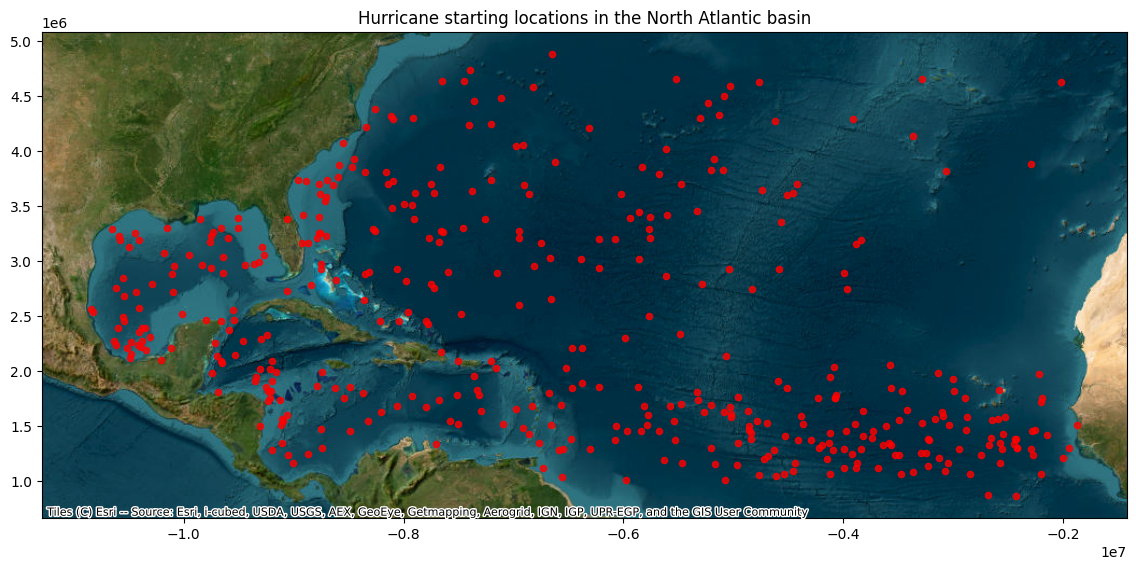

In [15]:
hurricane_map(Hurricanes, col=["red"])

## Data Cleaning

Before moving to the core of the analysis, I shall proceed in filtering and cleaning all the data that I gathered.\
So, I shall explore missing rows and proportion in the distribution of variables.

In [16]:
print(Hurricanes.shape)
print(Hurricanes["Damage(USD)"].notnull().sum())
print(Hurricanes["Fatalities"].notnull().sum())
mask = Hurricanes["Damage(USD)"].notnull() & Hurricanes["Fatalities"].notnull()
print(mask.sum())

(428, 15)
106
120
106


Convert needed columns to numeric

In [17]:
Hurricanes["Damage(USD)"] = pd.to_numeric(Hurricanes["Damage(USD)"], errors="coerce")
Hurricanes["Fatalities"] = pd.to_numeric(Hurricanes["Fatalities"], errors="coerce")

Hurricanes = Hurricanes.fillna(0)

Notice that some rows are missing for Fatalities and Damage (USD).\
For simplicity, I shall consider this events as 0/0 Fatalities and Damages.


### Identifying Y Label

Then, we can procede in building a binary variable to **ARBITRARILY** classify a hurrican as an Hazard risk, this is particularly true for example when hurricanes **make landfall**:
 > Hurricane making landfall: The storm's center (eye) has crossed the coastline and moved inland. This behavior is particularly dangerous since strong wind and heavy rain from the outer bands can affect areas even if the eye never actually reaches the shore.

In this context i shall consider some threshold among the collected variables, in order to create a binary variable `Hazard`.\
`Fatalities` and `Damages(USD)` will be surely considered in this case, but also Rain statistics could be informative, however, I would like to use the least variables as possible to make such an arbitrary decision, in order to be able to exploit the other variables in the context of Random Forests for classification of perillous events.

First, let me try to define an Hazard Hurrican as one with one or more fatalities, and one or more USD of damages (the second is not informative nor used in practice, but I would like to observe the distribution of splits).

In [18]:
Hurricanes["Hazard"] = (
    (Hurricanes["Damage(USD)"] > 0) | (Hurricanes["Fatalities"] > 0)
).astype(int)

print(Hurricanes["Hazard"].value_counts())


Hazard
0    310
1    118
Name: count, dtype: int64


Notice that if I use as threshold 1 fatality or 1$ damage, the lables already have different proportions, what if I consider a Dollar threshold for damages?

In [19]:
Hurricanes["Hazard"] = ((Hurricanes["Damage(USD)"] >= 1_000_000_000) | Hurricanes["Fatalities"] > 0).astype(int)
print(Hurricanes["Hazard"].value_counts())

Hazard
0    320
1    108
Name: count, dtype: int64


Since in this analysis I am trying to give a probability to catastrophic events tied to hurricanes dynamics, I have decided to use a very strict threshold for USD damage as 1 bln USD.\
Doing so, the proportion of Hazard Hurricanes, doesn't change as much because in the mask i also have a criteria for a single fatality.

Now, ethically it is of course disastrous when even just one fatality occurs and it I refuse put a threshold on human lives. 

For this reason, let me try to exclude this variable for a moment, since the scope of the analysis could be highly influenced by it.

In [20]:
def criteria(df,dollars):
    mask = df["Damage(USD)"] >= dollars
    print(mask.sum())

In [21]:
criteria(Hurricanes,1_000_000_000)

38


Notice that, deleting the criteria of fatalities leads to a much more reduced number of Hazardous Hurricanes at 1 bln USD threshold, let me try to reduce it.

In [22]:
criteria(Hurricanes,100_000_000)

63


At 100 MLN USD 63 instances.

In [23]:
criteria(Hurricanes, 10_000_000)

82


At 10 MLN USD 82 instances.

In [24]:
criteria(Hurricanes,1_000_000)

90


At 1 MLN USD 90 instances.

To decide my criteria, I shall return to the scope of the analysis.\
In the pricing of CAT BONDS the determinant is inevitably tied to USD Damage, more than the number of fatalities, because the payout is related to economic damages.\
However, `Fatalities` remain an important proxy in the analysis because one could have an indication of whether the Hurricane has reached inhabitated areas. For this reason I won't use `Fatalities` to identify an Hurrican Hazard **in this context**, but I could exploit the informative power of such statistics.

Further in the analysis i will use the 10 MLN USD threshold.

In [25]:
Hurricanes["Hazard"] = (Hurricanes["Damage(USD)"] >= 10_000_000)
print(Hurricanes["Hazard"].value_counts())

Hazard
False    346
True      82
Name: count, dtype: int64


Just as visual exploration, let me try to plot again the North Atlantic Hurricanes in my dataset, divided by Hazard/Not Hazard (defined by the 10MLN USD threshold) with different colors:

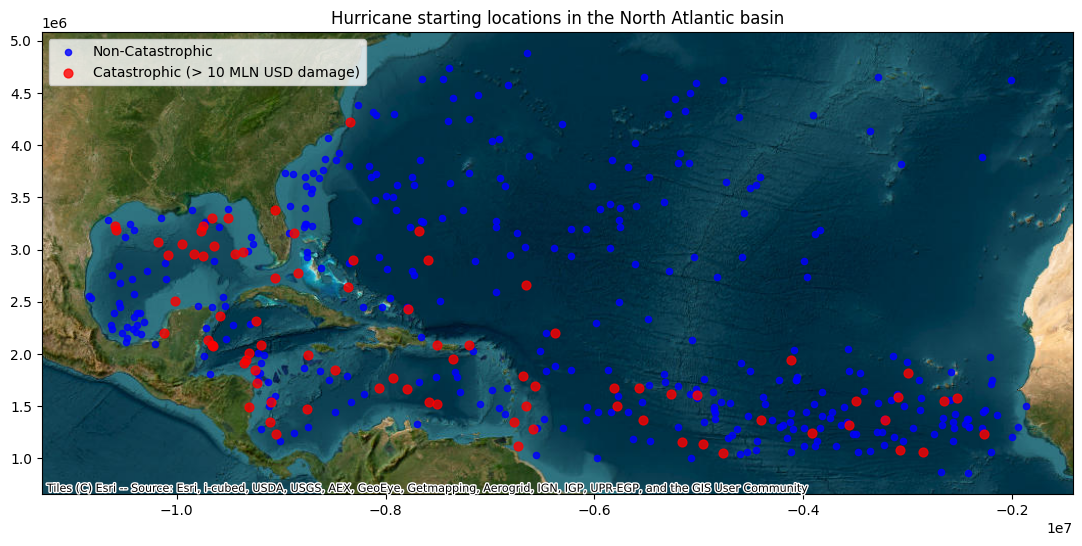

In [26]:
hurricane_map(Hurricanes,size = (14,6),col=["blue","red"])

It is indeed premature to identify clusters for catastrophic hurricanes, but some intuition may be drawn from this preliminary view:

- Hurricanes with starting location in the Northern-Eastern regiorn of the North Atlantic seems to have a lower probability of being catastrophic.
- A great portion of hurricanes (being them catastrophic or not) starts near the Tropics of Cancer, approximately between Africa and Central America.
- Catastrophic Hurricanes seem to either start near the coastline of Central America and Southern-Easter USA, or from the cluster observed in the previous point.
- A cluster of Non-Catastrophic hurricanes could be noticed in the Southern region of the Gulf of Mexico.

Moreover, given that the separation seems not to be completely ranomd, I could think that the arbitrary criteria chosen to define a Catastrophic hurricane could be a proper one.

> It is important to notice that this is an explanatory step, as further statistical validation will be necessary. These intutions will then of course be addressed in the next sections of the analysis, as Random Forest are expected to help us extrapolate a probability of being catastrophic, given a set of Features that will now be described.


`Hazard` is my Y Label.

Notice that if the threshold is increased to 1 BLN USD the most Catastrophic events are relegated even more strictly to the Tropics of the Cancer as starting location:

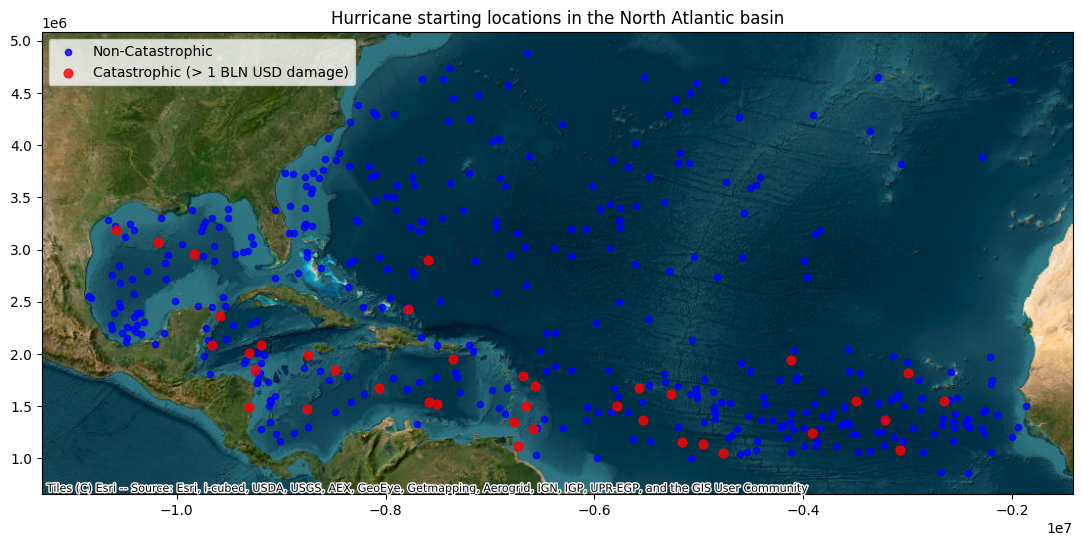

In [27]:
Hurricanes["Hazard"] = (Hurricanes["Damage(USD)"] >= 1_000_000_000)
hurricane_map(Hurricanes, size=(14,6), col=["blue","red"],tr=" (> 1 BLN USD damage)")

# Return to the chosen threshold
Hurricanes["Hazard"] = (Hurricanes["Damage(USD)"] >= 10_000_000)

### Features Selection

Now, let me move to the feature selection that will be used in the Random Forest classificator in order to predict the Catastrophic or Non-Catastrophic Hurricane.\
Let us first inspect the available features in the Data Frame `Hurricanes`.

In [28]:
Hurricanes.columns

Index(['id', 'Name', 'vmax', 'mslp', 'Category', 'ace', 'start_time',
       'end_time', 'start_lat', 'start_lon', 'Year', 'Rain Inch.',
       'Damage(USD)', 'Fatalities', 'Affected Areas', 'Hazard'],
      dtype='object')

In order to make the best use of the date column, I would like to create a new feature named `Season` to detect possible seasonality patterns.
> Notice that for simplicity I have defined a season assignment not by date but instead by month, so it will not be 100% accurate, but hopefully will help me in defining a predictive feature.

In [29]:
Hurricanes["start_time"] = pd.to_datetime(Hurricanes["start_time"])

def get_season(date):
    month = date.month

    if month in [1,2,3]:
        return 'Winter'
    elif month in [4,5,6]:
        return 'Spring'
    elif month in [7,8,9]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply the function to each row of the Data Frame
Hurricanes["Season"] = Hurricanes["start_time"].apply(get_season)
Hurricanes.head()


id     Name  vmax  mslp  Category   ace          start_time  \
0  AL012000  UNNAMED    25  1008        -1   0.0 2000-06-07 18:00:00   
1  AL022000  UNNAMED    30  1008        -1   0.0 2000-06-23 00:00:00   
2  AL032000  ALBERTO   110   950         3  36.9 2000-08-03 18:00:00   
3  AL042000  UNNAMED    30  1009        -1   0.0 2000-08-08 12:00:00   
4  AL052000    BERYL    45  1007         0   0.9 2000-08-13 18:00:00   

              end_time  start_lat  start_lon  Year  Rain Inch.  Damage(USD)  \
0  2000-06-08 12:00:00       21.0      -93.0  2000         0.0          0.0   
1  2000-06-25 18:00:00        9.5      -19.8  2000         0.0          0.0   
2  2000-08-23 06:00:00       10.8      -18.0  2000         0.0          0.0   
3  2000-08-11 12:00:00       28.2      -74.2  2000         0.0          0.0   
4  2000-08-15 18:00:00       22.5      -93.5  2000         0.0          0.0   

   Fatalities Affected Areas  Hazard  Season  
0         0.0              0   False  Spring  
1         0.0              0   False  Spring  
2         0.0              0   False  Summer  
3         0.0              0   False  Summer  
4         0.0              0   False  Summer

In the following cell I will define a new Data Frame with just the chosen X Features collected.\
In order to try and predict the Y lable I will try to exploit the following features:

> Note that: In Random Forest classifiers **Multicollinearity** is not a major issue in Random Forest classifiers, due to their enseble nature and feature selection process. So when choosing my variables I could give less importance to this matter.

However, given that the following variables are closely related, I will try and use only one on them.\

- `vmax`: Highest Wind speed;
- `Category`: Saffir-Simpson scale;
- `mslp`: Minimum Sea Level Pressure

The first two are basically the same thing, in particular the second is defined starting from the first one, so I shall immediately think into dropping one of them.\
Moreover, following [Zawislak (2022)](https://www.preventionweb.net/news/what-best-predictor-landfalling-hurricane-damage) it has been recently found that `MSLP` could be a better storm intensity metric for predicting historical hurricane damage; and in particular this is found to be especially notable for America's East Coast landfalls.

1. For this reason one of the selected features is `mslp`.

  > MSLP represents the lowest atmospheric pressure measured at sea level within a hurricane circulation. Lower MSLP indicate a more intense and powerful hurricane, with stronger winds and greater potential for damage.

2. Moving forward, `ace` (Accumulated Cyclone Energy) will be used given that it combines duration (yet to be included as proxy) and intensity (included before, but still overlooked as multicollinerity risk in this case for the importance of duration).

  $$
    ACE = 10^{-4} \sum{vmax^{2}}
  $$

  Notice that in the formula, `vmax` is collected every 6 hours, so as the Hurricane goes on the ACE will increase. (see that this is another reason the exclude the `vmax` variable alone).

3. `Season` will be used as seasonality can indeed provide useful predictive power as hurricanes patterns differs throughout the year.

4. (and 5.) are the coordinates, very important: `start_lat`, `start_lon`.

Finally, the variable `Rain (inch)` could have been useful in predicting for example flood damages, but unfortunately the data provided is incomplete and a imputation could yield to misleading results.



Now that we have defined a set of X Features and a Y target, let me collect them in two separate `df`.

In [30]:
features = ["mslp", "ace", "Season", "start_lat", "start_lon"]
X = Hurricanes[features].copy()
y = Hurricanes["Hazard"]

Now, given that `Season` is categorical, let me retrieve its dummies.

In [31]:
X = pd.get_dummies(X, columns=["Season"], drop_first=True).astype(int) # drop the categorical starting variable to avoid collinearity

In [32]:
X.head()

mslp  ace  start_lat  start_lon  Season_Spring  Season_Summer  \
0  1008    0         21        -93              1              0   
1  1008    0          9        -19              1              0   
2   950   36         10        -18              0              1   
3  1009    0         28        -74              0              1   
4  1007    0         22        -93              0              1   

   Season_Winter  
0              0  
1              0  
2              0  
3              0  
4              0

Notice that just three dummies are correctly created, even if the Seasons are 4.\
This is done every time, since it would be redundant to add a fourth variable that could be simply obtained when alle three of them are 0.

In [33]:
X.shape

(428, 7)

In [34]:
y.shape

(428,)

Just a quick check that X and y have the same number of observations.

## Random Forest Classifier

Let me now move to training and test split for the `Random Forest` classifier.\
Recall that we are training this classifier with historical data, in order to retreieve a predictive model for catastrophic events. Then need for historical data is due to the labeling of the `y targets` in MLN USD, that would not be possible via a scenario generating process.\
Once we have found a robust classifier I will then produce a set of Monte Carlo scenario for the relevant geographic features accepted as `X Features` in the Random Forest, and then estimate, for each sceanario, the probability of resulting in a **Catastrophic Hurricane** defined with a monetary threshold.

Moving to Random Forests:\ 
I will split my observations cronologically, using the one starting from **2017** as test data.

In [35]:
cutoff = 2017

# define a function for the splitting (for later use)

def split_override(Hurricanes, cutoff, features, seas=True):

    X = Hurricanes[features].copy()
    y = Hurricanes["Hazard"]

    if seas==True:
        X = pd.get_dummies(X, columns=["Season"], drop_first=True).astype(int)

    train_idx = Hurricanes["Year"] <= cutoff
    test_idx = Hurricanes["Year"] > cutoff

    X_train = X.loc[train_idx].copy()
    X_test = X.loc[test_idx].copy()
    y_train = y.loc[train_idx].copy()
    y_test = y.loc[test_idx].copy()

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_override(Hurricanes, cutoff, features)
X_train.head(5)

mslp  ace  start_lat  start_lon  Season_Spring  Season_Summer  \
0  1008    0         21        -93              1              0   
1  1008    0          9        -19              1              0   
2   950   36         10        -18              0              1   
3  1009    0         28        -74              0              1   
4  1007    0         22        -93              0              1   

   Season_Winter  
0              0  
1              0  
2              0  
3              0  
4              0

> As first note in my classifier, I will specified a `class_weights='balanced'` criteria in the `RandomForestClassifier()` method to account for the imbalance of catastrophic events in the splits.

We can choose the optimal number of trees by observing the behaviour of the Out Of Bag Error.

> OOB Error: is the mean prediction error on each training sample x_i, using only the trees that **did not** have x_i in their bootrasp sample. Since each OOB set is not used to train the model, it is a good test for the performance of the model.

In [36]:
# Let me define a simple pipeline for future use
def RFpipeline(xs=X_train, ys=y_train, ntrees=300, seed=42, maxf=(X_train.shape[1]+1), **kwargs):
    clf = RandomForestClassifier(n_estimators=ntrees, oob_score=True, class_weight='balanced', random_state=seed, max_features=maxf, **kwargs)
    clf.fit(xs, ys)
    return clf

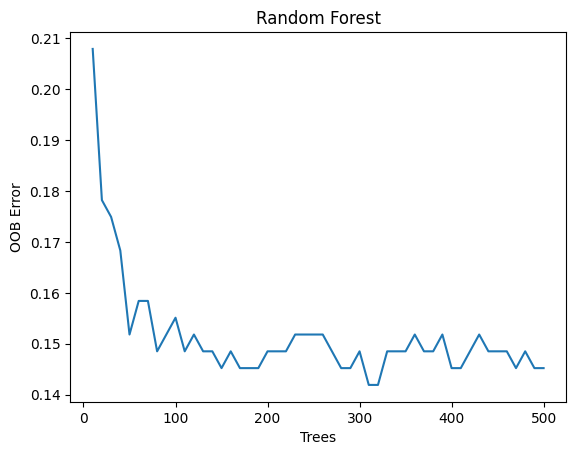

In [605]:
oob_errors = []
for n in range(10,501,10):
    clf = RFpipeline(ntrees=n)
    oob_errors.append(1- clf.oob_score_)

plt.plot(range(10,501,10), oob_errors)
plt.xlabel("Trees")
plt.ylabel("OOB Error")
plt.title("Random Forest")
plt.show()

From the OOB Error plot we notice that the error decreases and then fluctuates in a confined interval. This should suggest that adding additional trees is not so relevant after a certain point.\
In this case, it seems that after **150 trees** the error is pretty much stable, so I will use this as number of trees in my Random Forest Classifier with a parsimonious view.

Notice that the error is far from 0 in the training split, suggesting that overfitting should not be a problem in this case.


In [37]:
ntrees = 150

In order to increase the diversification among the different trees, let me try and inspect the behaviour of the OOB error and Test error with varying number of `max_features` criteria inside the `RandomForestClassifier()` method.

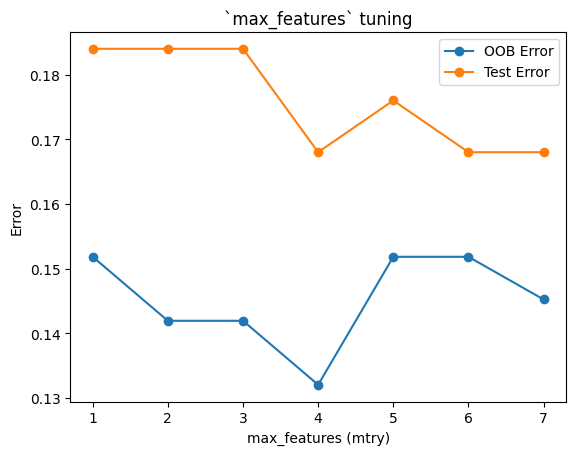

In [607]:
oob_errors = []
test_errors = []
mtry_range = range(1, X_train.shape[1] + 1)

for m in mtry_range:
    clf = RFpipeline(ntrees=ntrees,maxf=m)
    oob_error = 1 - clf.oob_score_  
    y_pred = clf.predict(X_test)
    test_error = 1 - accuracy_score(y_test, y_pred)

    oob_errors.append(oob_error)
    test_errors.append(test_error)

plt.plot(mtry_range, oob_errors, label='OOB Error', marker='o')
plt.plot(mtry_range, test_errors, label='Test Error', marker='o')
plt.xlabel('max_features (mtry)')
plt.ylabel('Error')
plt.title("`max_features` tuning")
plt.legend()
plt.show()




From the plot we understand that the OOB Error is minimized for 3 variables, but it does not vary as much between 1-4 variables; the Test error is also minimized at 3 variables.\
I will chose 3 variables as input for `max_features` options to try and generalize as much as possible, as 3 offers a good compromise minimization of the two errors.\
Including this specification I have limited the capacity of each tree to use all of the features, thus leading hopefully to more generlized results.

In [38]:
mtry = 3

### Model performance
Let me fit my final **Tuned** model.

Define a pipeline for the metrics since it will be used multiple times and one for plotting the confusion matrix.

In [58]:
def plot_cm(y_true, y_pred, labels=["Non-Catastrophic", "Catastrophic"]):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Random Forest')
    plt.show()

In [59]:
def metrics(model,xtrain=X_train, xtest=X_test, ytrain=y_train, ytest=y_test):

    y_pred = model.predict(xtest)

    # Accuracy
    acc_train = model.score(xtrain, ytrain)
    acc_test = model.score(xtest, ytest)

    print(f"OOB Score: {model.oob_score_:.4f}")
    print(f"Train accuracy: {acc_train:.4f}")
    print(f"Test accuracy: {acc_test:.4f}")

    print("\nComplete Report:")
    print(classification_report(ytest, y_pred))

    plot_cm(ytest, y_pred)

Evaluate predictions of the model:

RandomForestClassifier(class_weight='balanced', max_features=3,
                       n_estimators=150, oob_score=True, random_state=42)
OOB Score: 0.8581
Train accuracy: 1.0000
Test accuracy: 0.8160

Complete Report:
              precision    recall  f1-score   support

       False       0.87      0.91      0.89       100
        True       0.55      0.44      0.49        25

    accuracy                           0.82       125
   macro avg       0.71      0.68      0.69       125
weighted avg       0.80      0.82      0.81       125



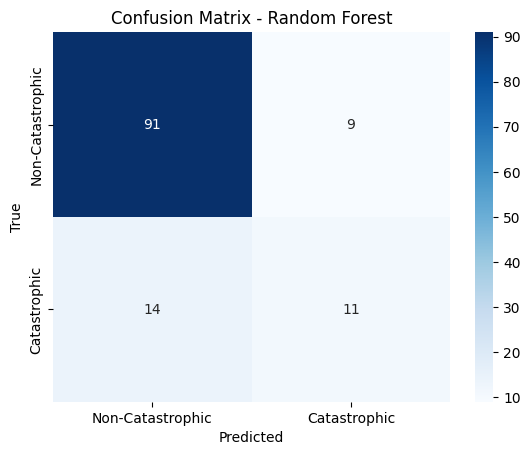

In [60]:
clf_model = RFpipeline(ntrees=ntrees,maxf=3)
print(clf_model)
metrics(clf_model)

We immediately observe a possible alarm signal, train accuracy is at 1.\
This is a particularly significant clue for overfitting, the model might be unable to generalize as needed. This is confirmed by the low recall and f1 scores for the True label.\
For this reason, we need to inspect other specification of the model in order to generalizes our classification properties.

Let us look a few example models, one can play with specifics of the `RandomForestClassifier()` method collected in the `RFpipeline()` function, by hand.

OOB Score: 0.8383
Train accuracy: 0.9340
Test accuracy: 0.8720

Complete Report:
              precision    recall  f1-score   support

       False       0.94      0.90      0.92       100
        True       0.66      0.76      0.70        25

    accuracy                           0.87       125
   macro avg       0.80      0.83      0.81       125
weighted avg       0.88      0.87      0.88       125



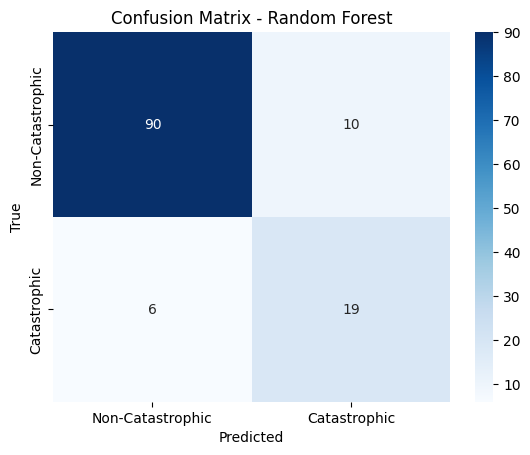

In [61]:
clf_model = RFpipeline(ntrees=ntrees,maxf=3,max_depth=5,min_samples_leaf=1,min_samples_split=2)
metrics(clf_model)

OOB Score: 0.8383
Train accuracy: 0.9274
Test accuracy: 0.8800

Complete Report:
              precision    recall  f1-score   support

       False       0.95      0.90      0.92       100
        True       0.67      0.80      0.73        25

    accuracy                           0.88       125
   macro avg       0.81      0.85      0.83       125
weighted avg       0.89      0.88      0.88       125



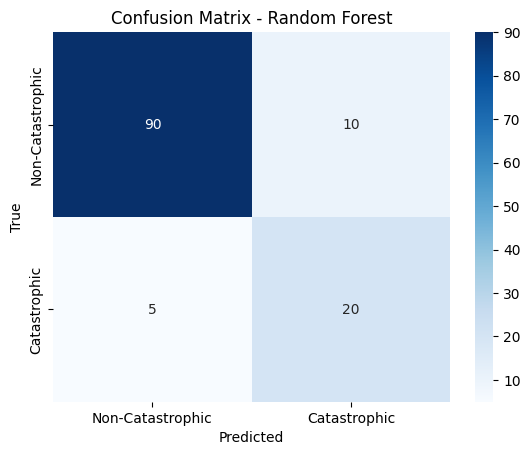

In [62]:
clf_model = RFpipeline(ntrees=ntrees,maxf=3,max_depth=5,min_samples_leaf=2,min_samples_split=3)
metrics(clf_model)

OOB Score: 0.8383
Train accuracy: 0.9043
Test accuracy: 0.8720

Complete Report:
              precision    recall  f1-score   support

       False       0.94      0.90      0.92       100
        True       0.66      0.76      0.70        25

    accuracy                           0.87       125
   macro avg       0.80      0.83      0.81       125
weighted avg       0.88      0.87      0.88       125



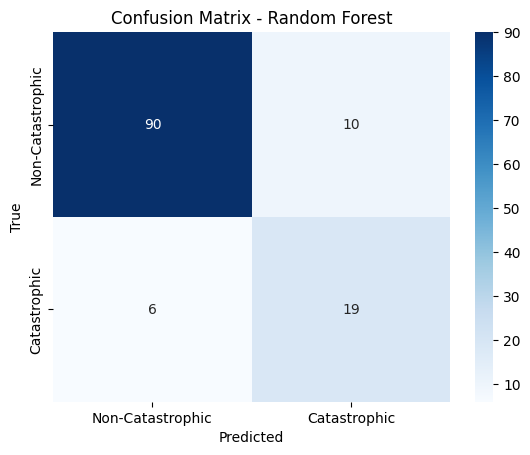

In [63]:
clf_model = RFpipeline(ntrees=ntrees,maxf=3,max_depth=5,min_samples_leaf=3,min_samples_split=3)
metrics(clf_model)

We can observe that by changing `max_depth`, `min_samples_leaf` and `min_samples_split` is possible to obtain a higher level of generalization.\
In order to define precisely which is the best configuration, without trying each one by hand we can use the `GridSearchCV()` method ok `sklearn.metrics` and search for the best configuration for a particular metrics, in this case let me find the best configuration for the `f1_score`:

In [51]:
param_grid = {
    'max_depth': [1, 3, 5, 7, 10, 12],
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'min_samples_split': [2, 3, 5, 10]
}

clf = RandomForestClassifier(n_estimators=ntrees,oob_score=True,class_weight='balanced',random_state=380,max_features=mtry)

scorer = make_scorer(f1_score, pos_label=1)
grid = GridSearchCV(clf, param_grid, scoring=scorer, cv=5)

grid.fit(X_train, y_train)
print(grid.best_params_)


{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}


Let me use the parameters obtained via Grid Search to fit the chosen model:

> Note that it also depends on the random state.

OOB Score: 0.8218
Train accuracy: 0.8944
Test accuracy: 0.8720

Complete Report:
              precision    recall  f1-score   support

       False       0.94      0.90      0.92       100
        True       0.66      0.76      0.70        25

    accuracy                           0.87       125
   macro avg       0.80      0.83      0.81       125
weighted avg       0.88      0.87      0.88       125



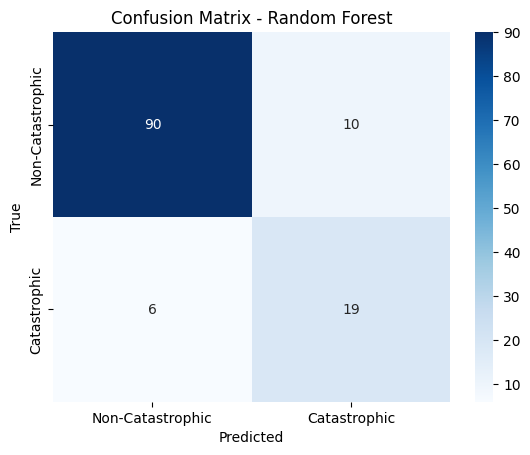

In [64]:
clf_final = RFpipeline(ntrees=ntrees,maxf=3,max_depth=5,min_samples_leaf=2,min_samples_split=10)
metrics(clf_final)

Recall and f1-score metrics are good for the true lable, and the accuracy in Train and Test is high but not 1.\
We shall proceed with this model.

### Feature Importance

Let me now investigate the **Feature Importance** in my model.

> `Feature importance`: in a Random Forest Classifier, each split in each tree decides which variables to use to split data and reduce impurity. Feature Importance gives an indication of how much a specific variable is used for **important splits** (the ones that reduce impurity significantly). In practice, feature importance tells me which variables really guide my predictions; moreover, it can be used for variable selection as features with importance near one can be removed.

In [65]:
feat_imp = pd.Series(clf_final.feature_importances_, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=True)
print(feat_imp)

Season_Winter    0.000000
Season_Spring    0.005819
Season_Summer    0.009576
ace              0.147781
start_lat        0.153023
start_lon        0.257473
mslp             0.426329
dtype: float64


- MSLP: is the most powerful predictor (40%), reinforcing the idea that a lower minimum pressure is a strong indicator for hurricane intensity;
- Starting Longitude and Latitute: nearly 40% combined, they confirm our orginating idea that starting coordinates have influence on landfall probability and therefore catastrophic impacts.
- ACE: contributes significantly, even if in smaller percentage (17%), as proxy for total power surged in the hurricane.
- Seasonal features show negligible importance, suggesting that the seasonal effect is already incorporated in the other variables.

Given this observations, I could finally try and fit the model without `Season` dummy variables to be considered explicitly.

OOB Score: 0.8251
Train accuracy: 0.9043
Test accuracy: 0.8640

Complete Report:
              precision    recall  f1-score   support

       False       0.94      0.89      0.91       100
        True       0.63      0.76      0.69        25

    accuracy                           0.86       125
   macro avg       0.79      0.82      0.80       125
weighted avg       0.88      0.86      0.87       125



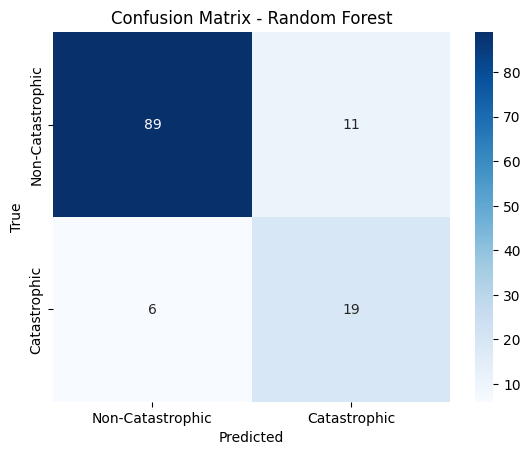

In [66]:
features2 = ["mslp", "ace", "start_lat", "start_lon"]
X_train2, X_test2, y_train2, y_test2 = split_override(Hurricanes, cutoff, features2, seas=False)

clf_final2 = RFpipeline(xs=X_train2, ys=y_train2, ntrees=ntrees,maxf=3,max_depth=5,min_samples_leaf=5,min_samples_split=2)
metrics(clf_final2,xtrain=X_train2, xtest=X_test2, ytrain=y_train2, ytest=y_test2)

Model accuracy, recall and precision nearly changes so I can leave the variable Season outside of the final model.\
Let me save my model:

In [56]:
joblib.dump(clf_final2, "random_forest_catbond.pkl")

['random_forest_catbond.pkl']

Given the final chosen model, that will be used in the next sections to make predictions on a set of scenarios, let me first try and plot its confusion matrix on the test set, on a `Satellite Map`.

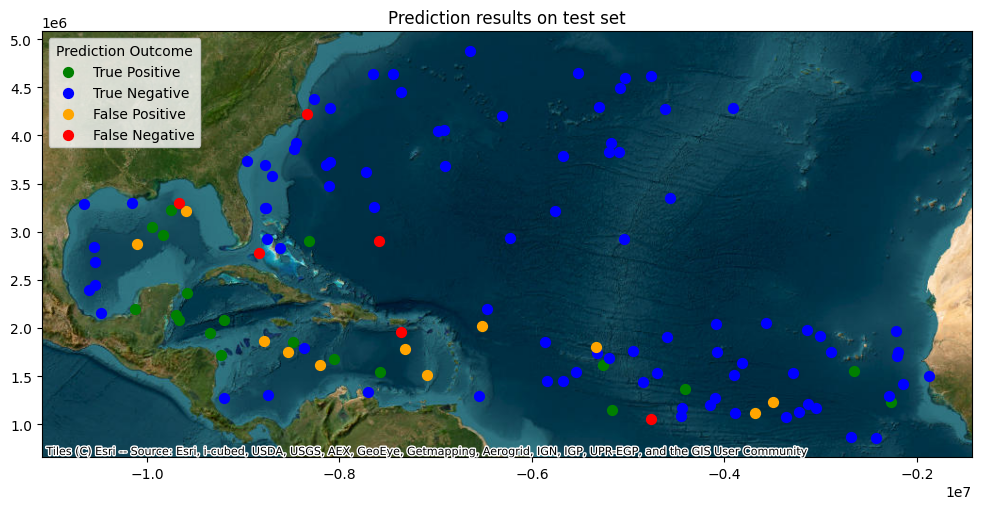

id     Name  vmax  mslp  Category  ace          start_time  \
303  AL012018  ALBERTO    55   990         0  1.8 2018-05-25 12:00:00   
304  AL022018    BERYL    70   991         1  4.8 2018-07-04 12:00:00   
305  AL032018    CHRIS    90   969         2  7.4 2018-07-06 12:00:00   
306  AL042018    DEBBY    45   998         0  1.5 2018-08-07 06:00:00   
307  AL052018  ERNESTO    40  1003         0  1.4 2018-08-15 06:00:00   

                end_time  start_lat  start_lon  Year  Rain Inch.  Damage(USD)  \
303  2018-05-31 00:00:00       18.8      -87.1  2018        11.8  125000000.0   
304  2018-07-15 18:00:00       10.0      -34.9  2018         0.0          0.0   
305  2018-07-12 12:00:00       31.5      -73.1  2018         0.0          0.0   
306  2018-08-09 12:00:00       36.0      -47.6  2018         0.0          0.0   
307  2018-08-17 18:00:00       37.4      -45.7  2018         0.0          0.0   

     Fatalities                                     Affected Areas  Hazard  \
303        18.0  Yucatán Peninsula -  Cuba -  Eastern United St...    True   
304         0.0                                                  0   False   
305         0.0                                                  0   False   
306         0.0                                                  0   False   
307         0.0                                                  0   False   

     Season  y_true  y_pred      confusion  
303  Spring    True    True  True Positive  
304  Summer   False   False  True Negative  
305  Summer   False   False  True Negative  
306  Summer   False   False  True Negative  
307  Summer   False   False  True Negative

In [69]:
df_test = Hurricanes.loc[Hurricanes["Year"] > cutoff].copy()
df_test["y_true"] = y_test2.values
df_test["y_pred"] = y_pred

# create column for each class in the confusion matrix
def confusion_label(row):
    if row.y_true == 1 and row.y_pred == 1:
        return "True Positive"
    elif row.y_true == 0 and row.y_pred == 0:
        return "True Negative"
    elif row.y_true == 0 and row.y_pred == 1:
        return "False Positive"
    else:
        return "False Negative"

df_test["confusion"] = df_test.apply(confusion_label, axis=1)

# GeoDataFrame
geometry = [Point(xy) for xy in zip(df_test["start_lon"], df_test["start_lat"])]
gdf = gpd.GeoDataFrame(df_test, geometry=geometry).set_crs(epsg=4326).to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
colors = {"True Positive": "green", "True Negative": "blue", "False Positive": "orange", "False Negative": "red"}

for label, color in colors.items():
    gdf[gdf["confusion"] == label].plot(ax=ax, markersize=50, color=color, label=label)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=4)
plt.legend(title="Prediction Outcome")
plt.title("Prediction results on test set")
plt.show()

df_test.head()


#### Some comments on the results of the predictions on the test set:

- The model is able to capture most of the **True Negatives** correctly on the Norther region of our basin (`blue` points);
- We can observe a cluster of **True positives** near the costal area of the Gulf of Mexico and Central America (`green` points);
- Most of the **False positives** are concetrated on the Tropics of the Cancer (`orange` points), maybe to to excessive caution of the model: still they are not as problematic as False negatives! 
- **False Negatives**, the most problematic predictions, are few and located mostly near the costal area (`red` points). In this case the model was not able to correctly classify their dinamics. Future research could maybe include other features like wind or currents directions, speed of movement, ecc.

> Most of the events are correctly classified so we can be pretty happy with our model.

## Scenario generating process

At this point of the analysis, it is interesting to use the trained `Random Forest Classifier` on a set of generated scenarios.\

1. First, let me explore the distribution of the X Features that will be simulated with Monte Carlo in the input space, in order to try and retrieve a good approximation of their underlying probability distribution.

2. Then, I will present two resampling methods: 

- `Bootstrapping` (Non-parametric)
- `Monte Carlo`(Parametric): assumptions on the underlying distribution are needed

3. In particular, I will use `Monte Carlo` to calculate the VaR (Value at Risk) and ES (Expected Shortfall) for a Cat portfolio on HURDAT2 hurricanes.

The `Resampling` method will be used to simulate n scenarios in the 4 **X Features** selected as predictors in the Classifier, namely:

- `mslp` `ace`;
- `start_lat` and `stat_lon`.

#### Bootstrapping:

The most important diffference between the two methods is that `Boostrapping` does not require any assumption on the underlying distribution; however it could be limiting in a **Stress-test** view since I am only resampling from my original sample.\

> Problem: in my case, since the number of observations in the sample is limited and the bootstrapped coordinates should match the **very large** number of Monte Carlo scenarios, the same location would be used thousands of times.

In order to avoid this problem and for simplicity of the analysis, I will introduce a small random normal perturbation in each genesis points retrieved with bootstrapping. 


#### Monte Carlo:

Being able to generate scenarios for an assumed underlying distribution is frequently used in Risk practitioners when calculating VaR in a set of scenarios, so I will try to identify the most appropriate `Marginal Distribution` for each feature included in the Random Forest Classifier.


#### Empirical Distribution

In [71]:
Hurricanes[features].describe()

mslp         ace   start_lat   start_lon
count   428.000000  428.000000  428.000000  428.000000
mean    983.268692    7.217757   20.566355  -59.189019
std      25.308592   10.825980    8.263706   22.555381
min     882.000000    0.000000    7.700000  -97.400000
25%     971.750000    1.000000   13.375000  -78.800000
50%     993.000000    2.700000   18.450000  -60.550000
75%    1002.000000    8.925000   27.700000  -40.000000
max    1016.000000   70.400000   40.100000  -16.800000

Text(0.5, 1.0, 'Empirical distribution of `start_lon`')

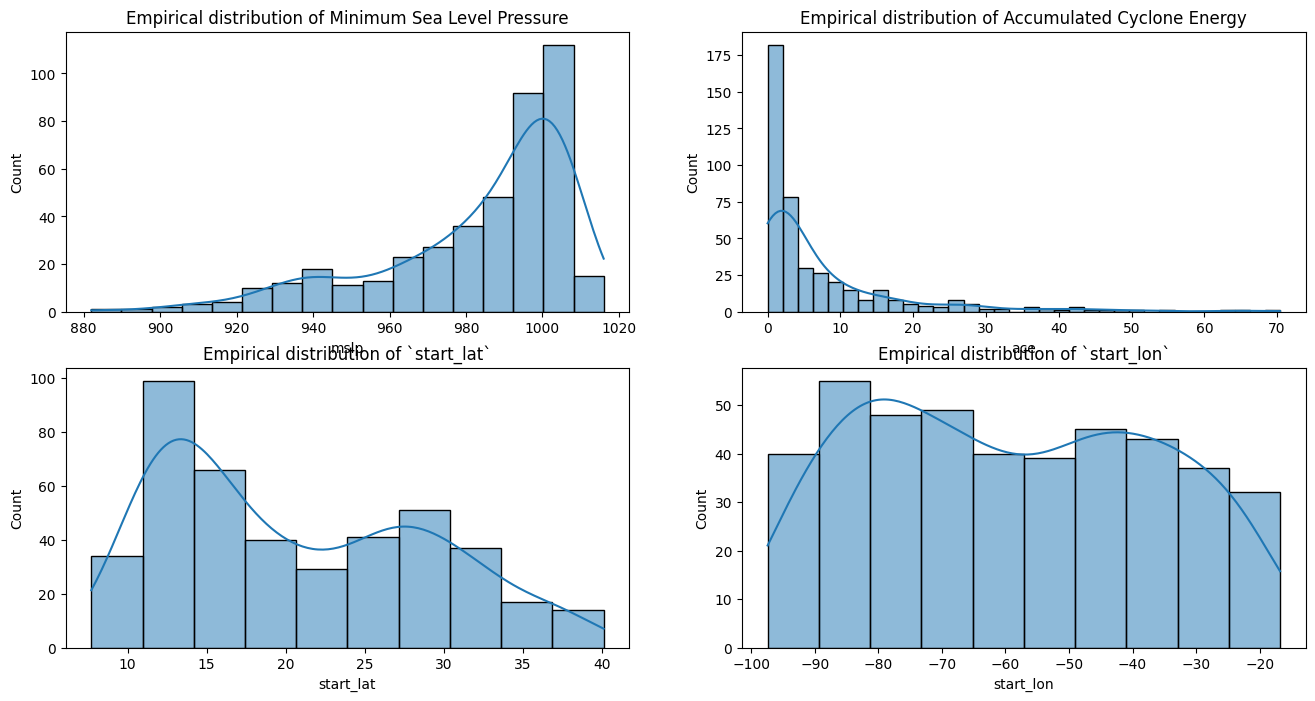

In [72]:
fig, ax = plt.subplots(2,2, figsize=(16,8))

sns.histplot(Hurricanes["mslp"].dropna(), kde=True, ax=ax[0,0])
ax[0,0].set_title("Empirical distribution of Minimum Sea Level Pressure")

sns.histplot(Hurricanes["ace"].dropna(), kde=True, ax=ax[0,1])
ax[0,1].set_title("Empirical distribution of Accumulated Cyclone Energy")

sns.histplot(Hurricanes["start_lat"].dropna(), kde=True, ax=ax[1,0])
ax[1,0].set_title("Empirical distribution of `start_lat`")

sns.histplot(Hurricanes["start_lon"].dropna(), kde=True, ax=ax[1,1])
ax[1,1].set_title("Empirical distribution of `start_lon`")



> Notice that none of the features has a Marginal Distribution that resembles for example a Gaussian, in particular `mslp` and `ace` are heavily skewed do to the presence of a smaller number of catastrophic events (as it should be in reality). The coordinates are insted somewhat similarly distributed as a uniform distribution, with some clusters.

In this context it would be better to generate the scenarios starting from the empirical distribution of the observed feature, but is important to notice that I shall not forget about the internal dependence of the variable.\
In particular, generating the scenarios independently would be theretically wrong since much of these features are tied to the other. For this reason i need to inspect first the covariance and correlation matrix. 

In [79]:
features = ["mslp", "ace", "start_lat", "start_lon"]
X = Hurricanes[features].copy()
y = Hurricanes["Hazard"]

In [84]:
corr = X.corr()
cov = X.cov()
corr

mslp       ace  start_lat  start_lon
mslp       1.000000 -0.836598   0.272979  -0.156659
ace       -0.836598  1.000000  -0.328243   0.329491
start_lat  0.272979 -0.328243   1.000000  -0.373538
start_lon -0.156659  0.329491  -0.373538   1.000000

In [85]:
cov

mslp         ace  start_lat   start_lon
mslp       640.524825 -229.219771  57.091497  -89.428250
ace       -229.219771  117.201839 -29.365514   80.456526
start_lat   57.091497  -29.365514  68.288842  -69.624079
start_lon  -89.428250   80.456526 -69.624079  508.745195

Notice that the features are **Far from independent**.

> In particular, as one should imagine `mslp` and `ace` are strongly inversely related. This is coherently with nature since as Pressure decreases, the event is more intense and the accumulated energy is higher!

Moreover, the features are also tied to the coordinates.

For this reason, it is important to state that the Features are not independent and a random generating process of scenarios would overlook their significant relationship.

In order to capture both these observation I would need to use a non-trivial **copula fitting** and more extensive calibration data, that is outside of the scope of this analysis and left for future work.

On the other hand, using a multivariate normal assumption to capture the dependance in the variables for the joint generation would be inconsistent with the empirical distributions we observe in our (limited sample), which are clearly non-Gaussian:

- `mslp` shows left-skewness and heavy tails,
- `ace` is strongly right-skewed,
- the geographical `coordinates` are closer to uniform distribution.

Therefore, in this work we decide to generate synthetic hurricane scenarios **independently** for each variable, directly respecting each variable’s empirical marginal distribution.

By producing a large number of scenarios (e.g., thousands or millions), we naturally capture a wide range of possible combinations, including both realistic and extreme edge cases. In the context of CAT bond pricing or risk management, this is reasonable: simulation methods such as Monte Carlo VaR or scenario-based stress testing do not strictly require that all simulated paths are perfectly physically plausible — instead, they are used to explore the tail risk space as thoroughly as possible.

## VaR on a set of simulated scenarios

I will load the trained Random Forest Classifier to retrieve the probability of catastrophic events in my simulated scenarios, given the X Features.

#### Cat Bond final step:

In this step we are basically trying to extrapolate the conditional probability:
$$
p = P(Y=1|X)
$$
where X is the set of features: `mslp`, `ace`, `start_lat`, `start_lon`.\
This probability is estiamated in each scenario.

Then, in order to extract a Binomial distribution of **trigger event**, I will use the `Bernoulli` with my conditional probability as input, to retrieve 0 or 1:
$$
catastrophic \approx Bernoulli(p)
$$

When the Bernoulli extracts 1, the payout is triggered.

Moreover, in order to relate the payout on the severity of the event, I will scale it for `mslp` (the most informative feature) when the payout is triggered.

$$
\text{payout} =
\begin{cases}
0, & \text{if } \text{hazard} = 0 \\
\text{payout}_{\text{max}} \times f(\text{severity}), & \text{if } \text{hazard} = 1
\end{cases}
$$

Let me define a function that will be use to compute VaR and ES and plot the `Simulated Loss Distribution` in the two cases:

In [112]:
def compute_var_es(loss, alpha=0.99, n_base=None, labels=("Base", "Stress")):
    VaR = np.quantile(loss, alpha)
    ES = loss[loss >= VaR].mean()

    plt.figure(figsize=(12, 6))
    if n_base:
        sns.kdeplot(loss[:n_base], label=labels[0], fill=True)
        sns.kdeplot(loss[n_base:], label=labels[1], fill=True, color='red')
    sns.kdeplot(loss, label="Combined", color='black')

    plt.axvline(VaR, linestyle='--', color='k', label=f"VaR {int(alpha*100)}%")
    plt.axvline(ES, linestyle=':', color='orange', label="Expected Shortfall")

    plt.title("Simulated Loss Distribution")
    plt.xlabel("Loss USD")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    print(f"VaR ({int(alpha*100)}%): {VaR:,.0f} USD")
    print(f"Expected Shortfall: {ES:,.0f} USD")

    return VaR, ES


Now, let me load the previously trained `Random Forest Classifier` to be used to predict Catastrophic events in both cases:

In [116]:
randomforest = joblib.load("random_forest_catbond.pkl")
randomforest

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=3,
                       min_samples_leaf=5, n_estimators=150, oob_score=True,
                       random_state=42)

### Boostrapping Simulations:

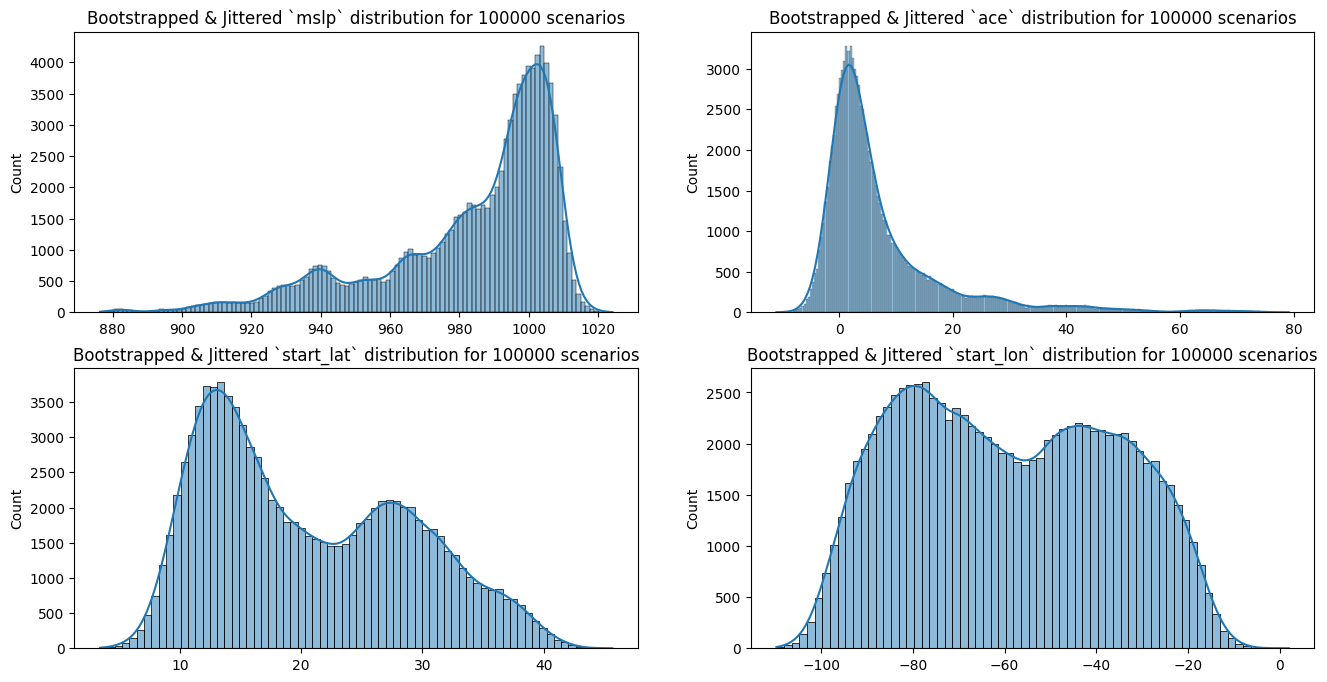

In [113]:
# Bootstrapping with perturbation
N = 100_000 

jitter_scales = {
    "mslp": 0.1,
    "ace": 0.25,
    "start_lat": 0.2,
    "start_lon": 0.2
}

def bootstrapping(feature, size, seed, jitter_scales, **kwargs):
    rng = np.random.default_rng(seed)
    bootstrapped = np.random.choice(Hurricanes[feature], size=size, replace=True)
    jitter_scale = jitter_scales.get(feature) * Hurricanes[feature].std()
    jitter = np.random.normal(loc=0, scale=jitter_scale, size=size)
    return pd.Series(bootstrapped + jitter)

simulated = {}
for feature in features:
    simulated[feature] = bootstrapping(feature, size=N, seed=42, jitter_scales=jitter_scales)


fig, ax = plt.subplots(2,2, figsize=(16,8))
sns.histplot(simulated["mslp"], kde=True, ax=ax[0,0])
ax[0,0].set_title(f"Bootstrapped & Jittered `mslp` distribution for {N} scenarios")
sns.histplot(simulated["ace"], kde=True, ax=ax[0,1])
ax[0,1].set_title(f"Bootstrapped & Jittered `ace` distribution for {N} scenarios")
sns.histplot(simulated["start_lat"], kde=True, ax=ax[1,0])
ax[1,0].set_title(f"Bootstrapped & Jittered `start_lat` distribution for {N} scenarios")
sns.histplot(simulated["start_lon"], kde=True, ax=ax[1,1])
ax[1,1].set_title(f"Bootstrapped & Jittered `start_lon` distribution for {N} scenarios")

X_mc = pd.DataFrame(simulated)

Dividing the scenarios between base and stressed.\
This will be useful in the Monte Carlo case, but let me do it now.

In [92]:
N_base = 80_000
N_stress = 20_000

Now, let me implement the process for VaR calculation highlighted at the beginning of the section:

> Note that to scale the payout I needed to define a `payout_max` variable that is completely arbitrary, but it can be arranged to different portfolios. Moreover, the loss is scaled by the `mslp` severity when the catastrophic event is triggered.

In [117]:
payout_max = 100_000_000 

In [118]:
# Catstrophic probability:
proba = randomforest.predict_proba(X_mc)[:, 1]

# Bernoulli draw:
np.random.seed(42)
hazard = np.random.binomial(1, proba)

# Loss:
severity = (Hurricanes["mslp"].max() - X_mc['mslp']) / (Hurricanes["mslp"].max() - Hurricanes["mslp"].min())
severity = severity.clip(0, 1)

loss = hazard * payout_max * severity

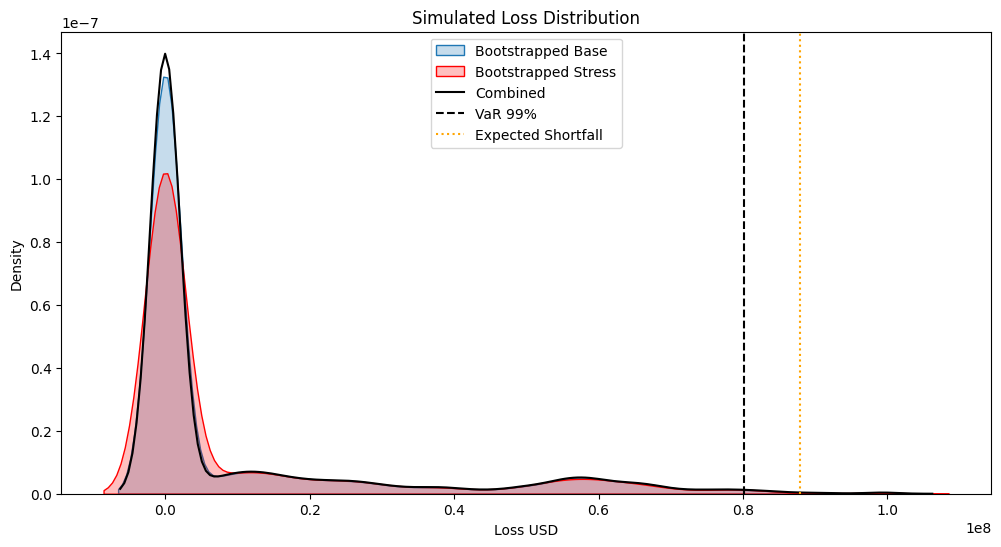

VaR (99%): 80,105,086 USD
Expected Shortfall: 87,887,111 USD


In [119]:
VaR_boot, ES_boot = compute_var_es(loss, alpha=0.99, n_base=N_base, labels=("Bootstrapped Base", "Bootstrapped Stress"))

Interpretation of the Simulated Loss Distribution:
The distribution confirms that most simulated scenarios result in zero or very limited losses, as the probability of a catastrophic payout remains low in historical-like conditions.
The right tail shows the possibility of extreme losses driven by high-intensity hurricanes (low mslp) hitting populated areas, even under independent marginal generation.
The 99% VaR (≈ USD 80M) indicates the threshold loss amount that will only be exceeded by 1% of scenarios.
The Expected Shortfall (≈ USD 88M) quantifies the average loss in the worst 1% cases, reflecting the tail risk that insurers must transfer or cover with capital buffers.
The close overlap of Base and Stress confirms that this split is purely illustrative here — a true stress scenario could shift the tail further right (e.g., by lowering mean mslp).

### Monte Carlo Simulations:

#### **Choice of Scenario Distributions**

In this part of the analysis, the core purpose of the scenario generator is to produce a wide synthetic distribution of hurricane features (`mslp`, `ace`, `coordinates`) coherent with the empirical historical data, yet flexible enough to explore extreme tails for risk estimation (**VaR** and **ES**).

- **MSLP (Minimum Sea Level Pressure)**  
  The empirical distribution shows evident left-skewness and heavy tails.  
  Therefore, a **skew-normal** distribution was chosen to reproduce both the asymmetry and the control over tail behavior.
  The skew parameter is negative to generate more intense hurricane scenarios with lower pressures.

- **ACE (Accumulated Cyclone Energy)**  
  The ACE shows clear right-skewness and positive values only, which naturally matches the **Gamma** distribution.
  This parametric choice respects non-negativity and long right tails, appropriate for high-energy cyclonic events.

- **Coordinates**  
  The geographical starting points (`lat` and `lon`) are sampled uniformly within their empirical bounds.  
  This is a simplifying assumption acknowledging that, at this stage, a more refined spatial distribution would require a more sophisticated model (copula or spatial kernel).  
  This is left as a future development.

The parameter values (mean, std, shape, scale) are directly estimated from the historical data.  
Stress scenarios push MSLP lower and ACE higher to replicate tail risks.

---

#### **Goodness-of-Fit and Robustness**

To support these assumptions, we perform basic diagnostic tests:
- QQ plots comparing empirical quantiles with theoretical ones
- Kolmogorov-Smirnov tests for goodness-of-fit  
- Comparison of empirical and simulated moments (mean, std, skewness)

Although these checks are limited by the small sample size, they support the idea that the chosen parametric families (skew-normal, Gamma) are reasonable approximations.


> **Note:**  
> A more advanced extension would be to replace these parametric marginals with kernel density estimates or a non-parametric copula to preserve dependencies across features.
> However, this is out of scope and left for future work.


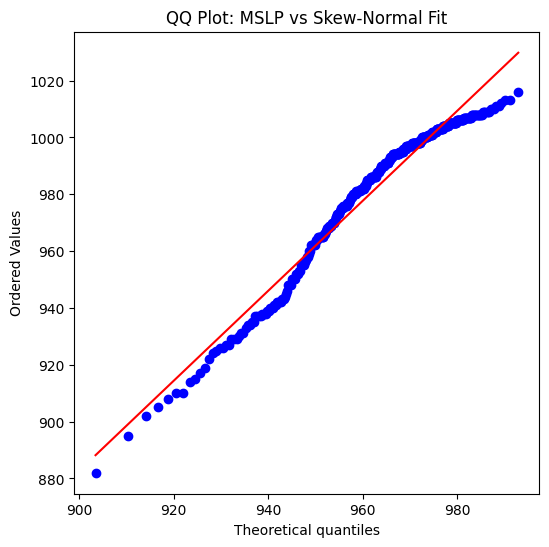

Kolmogorov-Smirnov test: D = 0.585, p-value = 0.0000


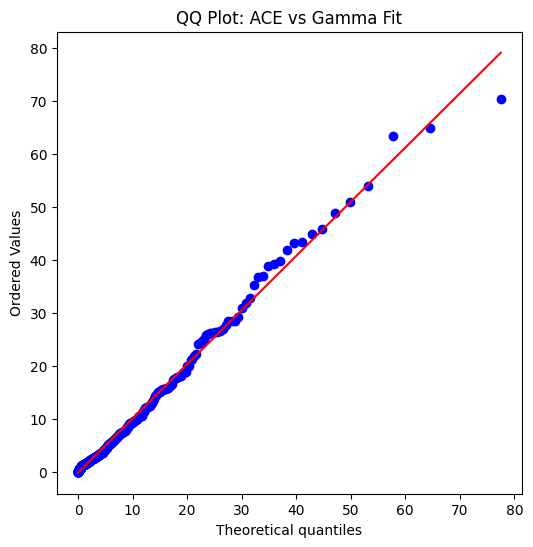

K-S ACE: D = 0.104, p-value = 0.0002


In [120]:
empirical = Hurricanes['mslp'].dropna()
mean_emp, std_emp = empirical.mean(), empirical.std()
skew_param = -5

simulated = skewnorm.rvs(skew_param, loc=mean_emp, scale=std_emp, size=len(empirical))

# QQ Plot
plt.figure(figsize=(6,6))
probplot(empirical, dist=skewnorm, sparams=(skew_param, mean_emp, std_emp), plot=plt)
plt.title("QQ Plot: MSLP vs Skew-Normal Fit")
plt.show()

# K-S Test
D, p_value = kstest(empirical, 'skewnorm', args=(skew_param, mean_emp, std_emp))
print(f"Kolmogorov-Smirnov test: D = {D:.3f}, p-value = {p_value:.4f}")

# Repeat for ACE with the Gamma distribution (only-positive)

empirical_ace = Hurricanes['ace'].dropna()
mean_ace, var_ace = empirical_ace.mean(), empirical_ace.var()
shape_ace = mean_ace**2 / var_ace
scale_ace = var_ace / mean_ace

sim_ace = gamma.rvs(shape_ace, scale=scale_ace, size=len(empirical_ace))

plt.figure(figsize=(6,6))
probplot(empirical_ace, dist=gamma, sparams=(shape_ace, 0, scale_ace), plot=plt)
plt.title("QQ Plot: ACE vs Gamma Fit")
plt.show()

D_ace, p_value_ace = kstest(empirical_ace, 'gamma', args=(shape_ace, 0, scale_ace))
print(f"K-S ACE: D = {D_ace:.3f}, p-value = {p_value_ace:.4f}")


> **Note on Goodness-of-Fit:**  
> The K-S test and QQ-plots show that simple parametric assumptions (Skew-Normal for MSLP, Gamma for ACE) do not perfectly match the empirical data (low p-values).  
> However, they reproduce the *key asymmetries and tail behaviors* required to generate realistic yet flexible stress scenarios.  
> This trade-off is acceptable for Monte Carlo tail risk analysis and consistent with common practice in risk simulation.
> A more precise modeling of the marginal or joint distributions could rely on non-parametric methods or copulas and is left as future research.


First let me divide between base and stress scenarios (useful in stress testing analysis):

In [121]:
np.random.seed(400)

# Empirical distribution parameters
mslp_mean = Hurricanes['mslp'].mean()
mslp_std = Hurricanes['mslp'].std()
mslp_skew = -5 

ace_mean = Hurricanes['ace'].mean()
ace_var = Hurricanes['ace'].var()
ace_shape = ace_mean**2 / ace_var
ace_scale = ace_var / ace_mean

lat_min, lat_max = Hurricanes['start_lat'].min(), Hurricanes['start_lat'].max()
lon_min, lon_max = Hurricanes['start_lon'].min(), Hurricanes['start_lon'].max()


# Generate N_base base scenarios
mslp_base = skewnorm.rvs(mslp_skew, loc=mslp_mean, scale=mslp_std, size=N_base)
ace_base = gamma.rvs(a=ace_shape, scale=ace_scale, size=N_base)
lat_base = np.random.uniform(lat_min, lat_max, N_base)
lon_base = np.random.uniform(lon_min, lon_max, N_base)

# Generate N_stress stressed scenarios
mslp_stress = skewnorm.rvs(mslp_skew, loc=mslp_mean - 2*mslp_std, scale=mslp_std, size=N_stress)
ace_stress = gamma.rvs(a=ace_shape, scale=ace_scale * 1.5, size=N_stress)
lat_stress = np.random.uniform(lat_min, lat_max, N_stress)
lon_stress = np.random.uniform(lon_min, lon_max, N_stress)

# combine
X_base = pd.DataFrame({
    'mslp': mslp_base,
    'ace': ace_base,
    'start_lat': lat_base,
    'start_lon': lon_base
})

X_stress = pd.DataFrame({
    'mslp': mslp_stress,
    'ace': ace_stress,
    'start_lat': lat_stress,
    'start_lon': lon_stress
})

X_mc = pd.concat([X_base, X_stress], ignore_index=True)

Now, we repeat the process as before to estimate VaR and ES and plot the Loss distribution

In [122]:
# Catastrophic probabilities
proba = randomforest.predict_proba(X_mc)[:, 1]

# Bernoulli drow
severity = (Hurricanes["mslp"].max() - X_mc['mslp']) / (Hurricanes["mslp"].max() - Hurricanes["mslp"].min())
severity = severity.clip(0, 1)

np.random.seed(42)
hazard = np.random.binomial(1, proba)
loss = hazard * payout_max * severity

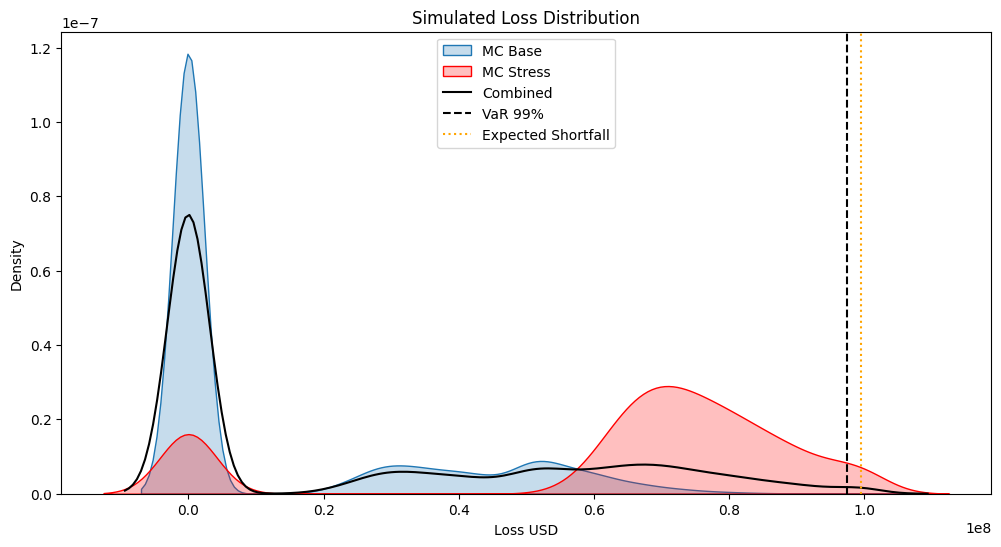

VaR (99%): 97,417,481 USD
Expected Shortfall: 99,604,365 USD


In [124]:
VaR_mc, ES_mc = compute_var_es(loss, alpha=0.99, n_base=N_base, labels=("MC Base", "MC Stress"))

In this case the `Simulated Loss Distribution` under the **Monte Carlo framework**, highlights the effect of explicitly adding a *Stress block* (red) to the base scenarios (blue).\
By design, the stress block generates more **extreme hurricane scenarios** — with lower `MSLP` and higher `ACE` — pushing more probability mass into the right tail of the loss distribution.

This explains why the combined curve (black) displays a **fatter tail**, resulting in a **higher VaR (99%) and Expected Shortfall (ES)** compared to a purely empirical or bootstrapped approach.\ 
The stress component ensures that tail events — which are rare in historical data — are systematically sampled, providing a more conservative estimate of potential catastrophic losses. A common practice in risk management offices.

## Conclusions

This final section highlights the difference between two scenario generation approaches used to simulate potential catastrophic hurricane losses: **Bootstrapping** and **Monte Carlo (Parametric)**.


#### Bootstrapping

The bootstrapping method resamples directly from the empirical historical data, adding only a mild random jitter to avoid duplicated genesis points.

- **Pros:** Realistic and fully data-driven. Preserves empirical dependencies and marginal distributions without any parametric assumptions.
- **Cons:** Limited by the size and variety of the historical dataset. Cannot easily explore extreme tail events that have not yet been observed in the available record.

The resulting loss distribution shows that the majority of scenarios cluster around moderate losses, with only a few natural tail events emerging.  
Consequently, the Value at Risk (**VaR**) and Expected Shortfall (**ES**) remain lower, reflecting the moderate severity of past hurricanes.


#### Monte Carlo (Parametric)

In contrast, the Monte Carlo approach combines parametric assumptions for each feature:
- `MSLP` is sampled from a skew-normal distribution to capture left-skewness and allow extremely low pressures, representative of intense hurricanes.
- `ACE` is sampled from a gamma distribution, consistent with its right-skewed, strictly positive nature.
- `Starting coordinates` are drawn from uniform ranges as a simple spatial proxy, acknowledging that a refined kernel would require a more complex model.

This method explicitly generates **stress scenarios** by systematically shifting MSLP lower and ACE higher, creating synthetic hurricanes that are **more severe than any single historical event**.  
This makes it possible to expand tail risk estimation, which is critical for robust CAT bond structuring and regulatory stress testing.

- **Pros:** Enables exploration of extreme but plausible tail scenarios. Flexible and easily scalable to stress assumptions.
- **Cons:** Requires parametric assumptions which might not fully reflect the true marginal and joint behavior of the features. Potentially ignores empirical dependencies unless a dependence structure (e.g., copula) is modeled explicitly.


##### Risk Metrics Interpretation

The **Monte Carlo VaR and ES** are systematically higher than the bootstrapped estimates:
- **VaR (99%)** defines the loss threshold that should not be exceeded with 99% confidence.
- **Expected Shortfall (ES)** measures the *average* loss in the tail beyond VaR, capturing the severity of the worst-case cluster of events.

The widening gap between VaR and ES confirms the **fat-tail nature** of catastrophic hurricane losses: once a severe scenario materializes, the associated damage can escalate well beyond typical historical levels.

#### Practical Implications

Bootstrapping is best suited for replicating typical year-to-year loss behavior within the range of observed data.  
Monte Carlo, on the other hand, is indispensable for stress testing, capital allocation, and risk transfer structures that must be resilient to rare but extreme tail events.

Together, these two complementary approaches provide a more robust perspective on potential hurricane risks:
- **Historical realism** through empirical resampling
- **Forward-looking stress tests** through parametric scenario generation

---

#### Future Extensions

This framework can be further improved by:
- Implementing **non-parametric copulas** to jointly simulate the strong dependencies between physical fea
